# Machine Learning in Julia (continued)

An introduction to the
[MLJ](https://alan-turing-institute.github.io/MLJ.jl/stable/)
toolbox.

### Set-up

Inspect Julia version:

In [1]:
VERSION

v"1.6.3"

The following instantiates a package environment.

The package environment has been created using **Julia 1.6** and may not
instantiate properly for other Julia versions.

In [2]:
using Pkg
Pkg.activate("env")
Pkg.instantiate()

  Activating environment at `~/GoogleDrive/Julia/MLJ/MLJTutorial/notebooks/02_models/env/Project.toml`
Precompiling project...
  ✓ MLJBase
  ✓ MLJEnsembles
  ✓ MLJIteration
  ✓ MLJTuning
  ✓ MLJSerialization
  ✓ MLJModels
  ✓ MLJ
  ✓ Plots
  8 dependencies successfully precompiled in 44 seconds (200 already precompiled)


## General resources

- [MLJ Cheatsheet](https://alan-turing-institute.github.io/MLJ.jl/dev/mlj_cheatsheet/)
- [Common MLJ Workflows](https://alan-turing-institute.github.io/MLJ.jl/dev/common_mlj_workflows/)
- [MLJ manual](https://alan-turing-institute.github.io/MLJ.jl/dev/)
- [Data Science Tutorials in Julia](https://juliaai.github.io/DataScienceTutorials.jl/)

## Part 2 - Selecting, Training and Evaluating Models

> **Goals:**
> 1. Search MLJ's database of model metadata to identify model candidates for a supervised learning task.
> 2. Evaluate the performance of a model on a holdout set using basic `fit!`/`predict` work-flow.
> 3. Inspect the outcomes of training and save these to a file.
> 3. Evaluate performance using other resampling strategies, such as cross-validation, in one line, using `evaluate!`
> 4. Plot a "learning curve", to inspect performance as a function of some model hyper-parameter, such as an iteration parameter

The "Hello World!" of machine learning is to classify Fisher's
famous iris data set. This time, we'll grab the data from
[OpenML](https://www.openml.org):

In [3]:
using MLJ
OpenML.describe_dataset(61)

[ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]


**Author**: R.A. Fisher   **Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall   **Please cite**:   

**Iris Plants Database**   This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is     linearly separable from the other 2; the latter are NOT linearly separable from each other.

Predicted attribute: class of iris plant.   This is an exceedingly simple domain.  

### Attribute Information:

```
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
   -- Iris Setosa
   -- Iris Versicolour
   -- Iris Virginica
```


In [4]:
iris = OpenML.load(61); # a column dictionary table

using DataFrames
iris = DataFrames.DataFrame(iris);
first(iris, 4)

,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


**Main goal.** To build and evaluate models for predicting the
`:class` variable, given the four remaining measurement variables.

### Step 1. Inspect and fix scientific types

In [5]:
schema(iris)

┌─────────────┬──────────────────────────────────┬───────────────┐
│ _.names     │ _.types                          │ _.scitypes    │
├─────────────┼──────────────────────────────────┼───────────────┤
│ sepallength │ Float64                          │ Continuous    │
│ sepalwidth  │ Float64                          │ Continuous    │
│ petallength │ Float64                          │ Continuous    │
│ petalwidth  │ Float64                          │ Continuous    │
│ class       │ CategoricalValue{String, UInt32} │ Multiclass{3} │
└─────────────┴──────────────────────────────────┴───────────────┘
_.nrows = 150


These look fine.

### Step 2. Split data into input and target parts

Here's how we split the data into target and input features, which
is needed for MLJ supervised models. We randomize the data at the
same time:

In [6]:
y, X = unpack(iris, ==(:class), name->true; rng=123);
scitype(y)

AbstractVector{ScientificTypesBase.Multiclass{3}} (alias for AbstractArray{ScientificTypesBase.Multiclass{3}, 1})

Here's one way to access the documentation (at the REPL, `?unpack`
also works):

In [7]:
@doc unpack

```
t1, t2, ...., tk = unpack(table, f1, f2, ... fk;
                         wrap_singles=false,
                         shuffle=false,
                         rng::Union{AbstractRNG,Int,Nothing}=nothing)
```

Horizontally split any Tables.jl compatible `table` into smaller tables (or vectors) `t1, t2, ..., tk` by making column selections **without replacement** by successively applying the columnn name filters `f1`, `f2`, ..., `fk`. A *filter* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`. For example, use the filter `_ -> true` to pick up all remaining columns of the table.

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

Scientific type conversions can be optionally specified (note semicolon):

```
unpack(table, t...; col1=>scitype1, col2=>scitype2, ... )
```

If `shuffle=true` then the rows of `table` are first shuffled, using the global RNG, unless `rng` is specified; if `rng` is an integer, it specifies the seed of an automatically generated Mersenne twister. If `rng` is specified then `shuffle=true` is implicit.

### Example

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=["A", "B"])
julia> Z, XY = unpack(table, ==(:z), !=(:w);
               :x=>Continuous, :y=>Multiclass)
julia> XY
2×2 DataFrame
│ Row │ x       │ y            │
│     │ Float64 │ Categorical… │
├─────┼─────────┼──────────────┤
│ 1   │ 1.0     │ 'a'          │
│ 2   │ 2.0     │ 'b'          │

julia> Z
2-element Array{Float64,1}:
 10.0
 20.0
```


### On searching for a model

Here's how to see *all* models (not immediately useful):

In [8]:
all_models = models()

183-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = AEDetector, package_name = OutlierDetectionNetworks, ... )
 (name = ARDRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, pa

Each entry contains metadata for a model whose defining code is not yet loaded:

In [9]:
meta = all_models[3]

AEDetector from OutlierDetectionNetworks.jl.
[Documentation](https://github.com/OutlierDetectionJL/OutlierDetectionNetworks.jl).
(name = "AEDetector",
 package_name = "OutlierDetectionNetworks",
 is_supervised = false,
 abstract_type = MLJModelInterface.UnsupervisedDetector,
 deep_properties = (),
 docstring = "AEDetector from OutlierDetectionNetworks.jl.\n[Documentation](https://github.com/OutlierDetectionJL/OutlierDetectionNetworks.jl).",
 fit_data_scitype = Tuple{Union{ScientificTypesBase.Table{_s52} where _s52<:(AbstractVector{_s51} where _s51<:ScientificTypesBase.Continuous), AbstractMatrix{_s689} where _s689<:ScientificTypesBase.Continuous}},
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Flux.Chain", "Flux.Chain", "Integer", "Integer", "Bool", "Bool", "Any", "Function"),
 hyperparameters = (:encoder, :decoder, :batchsize, :epochs, :shuffle, :partial, :opt, :loss),
 implemented_methods = [:clean!, :fit,

In [10]:
targetscitype = meta.target_scitype

AbstractVector{_s689} where _s689<:Union{Missing, ScientificTypesBase.OrderedFactor{2}} (alias for AbstractArray{_s689, 1} where _s689<:Union{Missing, ScientificTypesBase.OrderedFactor{2}})

In [11]:
scitype(y) <: targetscitype

false

So this model won't do. Let's  find all pure julia classifiers:

In [12]:
filter_julia_classifiers(meta) =
    AbstractVector{Finite} <: meta.target_scitype &&
    meta.is_pure_julia

models(filter_julia_classifiers)

21-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClas

Find all models with "Classifier" in `name` (or `docstring`):

In [13]:
models("Classifier")

45-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, packa

Find all (supervised) models that match my data!

In [14]:
models(matching(X, y))

47-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateS

### Step 3. Select and instantiate a model

To load the code defining a new model type we use the `@load` macro:

In [15]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux[ Info: Precompiling MLJFlux [094fc8d1-fd35-5302-93ea-dabda2abf845]
 ✔


MLJFlux.NeuralNetworkClassifier

Other ways to load model code are described
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/loading_model_code/#Loading-Model-Code).

We'll instantiate this type with default values for the
hyperparameters:

In [16]:
model = NeuralNetworkClassifier()

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = ComputationalResources.CPU1{Nothing}(nothing))

In [17]:
info(model)

A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. 
→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).
→ do `@load NeuralNetworkClassifier pkg="MLJFlux"` to use the model.
→ do `?NeuralNetworkClassifier` for documentation.
(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 abstract_type = MLJModelInterface.Probabilistic,
 deep_properties = (:optimiser, :builder),
 docstring = "A neural network model for making probabilistic predictions of a `Multiclass` or `OrderedFactor` target, given a table of `Continuous` features. \n→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).\n→ do `@load NeuralNetworkClassifier pkg=\"MLJFlux\"` to use the model.\n→ do `?NeuralNetworkClassifier` for documentation.",
 fit_data_scitype = Tuple{ScientificTypesBase.Table{var"#s53"} where var"#s53"<:(AbstractVector{var"#s52"} where var"#s

In MLJ a *model* is just a struct containing hyper-parameters, and
that's all. A model does not store *learned* parameters. Models are
mutable:

In [18]:
model.epochs = 12

12

And all models have a key-word constructor that works once `@load`
has been performed:

In [19]:
NeuralNetworkClassifier(epochs=12) == model

true

### On fitting, predicting, and inspecting models

In MLJ a model and training/validation data are typically bound
together in a machine:

In [20]:
mach = machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…},…} trained 0 times; caches data
  args: 
    1:	Source @922 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @606 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


A machine stores *learned* parameters, among other things. We'll
train this machine on 70% of the data and evaluate on a 30% holdout
set. Let's start by dividing all row indices into `train` and `test`
subsets:

In [21]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  96, 97, 98, 99, 100, 101, 102, 103, 104, 105], [106, 107, 108, 109, 110, 111, 112, 113, 114, 115  …  141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

Now we can `fit!`...

In [22]:
fit!(mach, rows=train, verbosity=2)

[ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
[ Info: Loss is 1.085
[ Info: Loss is 1.077
[ Info: Loss is 1.075
[ Info: Loss is 1.089
[ Info: Loss is 1.07
[ Info: Loss is 1.059
[ Info: Loss is 1.046
[ Info: Loss is 1.002
[ Info: Loss is 1.06
[ Info: Loss is 1.015
[ Info: Loss is 1.018
[ Info: Loss is 1.001


Machine{NeuralNetworkClassifier{Short,…},…} trained 1 time; caches data
  args: 
    1:	Source @922 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @606 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


... and `predict`:

In [23]:
yhat = predict(mach, rows=test);  # or `predict(mach, Xnew)`
yhat[1:3]

3-element MLJBase.UnivariateFiniteVector{ScientificTypesBase.Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.236, Iris-versicolor=>0.368, Iris-virginica=>0.396)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.219, Iris-versicolor=>0.377, Iris-virginica=>0.404)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.326, Iris-versicolor=>0.342, Iris-virginica=>0.332)

We'll have more to say on the form of this prediction shortly.

After training, one can inspect the learned parameters:

In [24]:
fitted_params(mach)

(chain = Chain(Chain(Dense(4, 3, σ), Dropout(0.5), Dense(3, 3)), softmax),)

Everything else the user might be interested in is accessed from the
training *report*:

In [25]:
report(mach)

(training_losses = [1.0861040699057927, 1.0850897919767752, 1.0769053903007801, 1.0750227728096013, 1.089012598973693, 1.0704945614082946, 1.0594718355110957, 1.0464876223048019, 1.0018646685106747, 1.059771648406736, 1.0152558096358695, 1.0180116154154317, 1.001068094119868],)

You save a machine like this:

In [26]:
MLJ.save("neural_net.jlso", mach)

And retrieve it like this:

In [27]:
mach2 = machine("neural_net.jlso")
yhat = predict(mach2, X);
yhat[1:3]

3-element MLJBase.UnivariateFiniteVector{ScientificTypesBase.Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.203, Iris-versicolor=>0.366, Iris-virginica=>0.431)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.236, Iris-versicolor=>0.37, Iris-virginica=>0.395)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.21, Iris-versicolor=>0.384, Iris-virginica=>0.407)

If you want to fit a retrieved model, you will need to bind some data to it:

In [28]:
mach3 = machine("neural_net.jlso", X, y)
fit!(mach3)

[ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @879 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @071 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


Machines remember the last set of hyper-parameters used during fit,
which, in the case of iterative models, allows for a warm restart of
computations in the case that only the iteration parameter is
increased:

In [29]:
model.epochs = model.epochs + 4
fit!(mach, rows=train, verbosity=2)

[ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
[ Info: Loss is 1.043
[ Info: Loss is 1.01
[ Info: Loss is 0.9724
[ Info: Loss is 1.002


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  args: 
    1:	Source @922 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @606 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


For this particular model we can also increase `:learning_rate`
without triggering a cold restart:

In [30]:
model.epochs = model.epochs + 4
model.optimiser.eta = 10*model.optimiser.eta
fit!(mach, rows=train, verbosity=2)

[ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
[ Info: Loss is 0.9614
[ Info: Loss is 0.8292
[ Info: Loss is 0.7718
[ Info: Loss is 0.7561


Machine{NeuralNetworkClassifier{Short,…},…} trained 3 times; caches data
  args: 
    1:	Source @922 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @606 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


However, change any other parameter and training will restart from
scratch:

In [31]:
model.lambda = 0.001
fit!(mach, rows=train, verbosity=2)

[ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
[ Info: Loss is 1.086
[ Info: Loss is 1.042
[ Info: Loss is 0.8886
[ Info: Loss is 0.8922
[ Info: Loss is 0.8259
[ Info: Loss is 0.7921
[ Info: Loss is 0.7022
[ Info: Loss is 0.7267
[ Info: Loss is 0.6664
[ Info: Loss is 0.7875
[ Info: Loss is 0.6484
[ Info: Loss is 0.6612
[ Info: Loss is 0.7152
[ Info: Loss is 0.6611
[ Info: Loss is 0.6801
[ Info: Loss is 0.6801
[ Info: Loss is 0.6743
[ Info: Loss is 0.7638
[ Info: Loss is 0.7066
[ Info: Loss is 0.6635


Machine{NeuralNetworkClassifier{Short,…},…} trained 4 times; caches data
  args: 
    1:	Source @922 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @606 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


Iterative models that implement warm-restart for training can be
controlled externally (eg, using an out-of-sample stopping
criterion). See
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/)
for details.

Let's train silently for a total of 50 epochs, and look at a
prediction:

In [32]:
model.epochs = 50
fit!(mach, rows=train)
yhat = predict(mach, X[test,:]); # or predict(mach, rows=test)
yhat[1]

[ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
Optimising neural net:100%[=========================] Time: 0:00:01


UnivariateFinite{ScientificTypesBase.Multiclass{3}}(Iris-setosa=>0.141, Iris-versicolor=>0.55, Iris-virginica=>0.308)

What's going on here?

In [33]:
info(model).prediction_type

:probabilistic

**Important**:
- In MLJ, a model that can predict probabilities (and not just point values) will do so by default.
- For most probabilistic predictors, the predicted object is a `Distributions.Distribution` object, supporting the `Distributions.jl` [API](https://juliastats.org/Distributions.jl/latest/extends/#Create-a-Distribution-1) for such objects. In particular, the methods `rand`,  `pdf`, `logpdf`, `mode`, `median` and `mean` will apply, where appropriate.

So, to obtain the probability of "Iris-virginica" in the first test
prediction, we do

In [34]:
pdf(yhat[1], "Iris-virginica")

0.3083039233899632

To get the most likely observation, we do

In [35]:
mode(yhat[1])

CategoricalArrays.CategoricalValue{String, UInt32} "Iris-versicolor"

These can be broadcast over multiple predictions in the usual way:

In [36]:
broadcast(pdf, yhat[1:4], "Iris-versicolor")

4-element Vector{Float64}:
 0.5504965452205032
 0.5154036056708229
 0.05542404604641261
 0.4085753827071587

In [37]:
mode.(yhat[1:4])

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-virginica"

Or, alternatively, you can use the `predict_mode` operation instead
of `predict`:

In [38]:
predict_mode(mach, X[test,:])[1:4] # or predict_mode(mach, rows=test)[1:4]

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-virginica"

For a more conventional matrix of probabilities you can do this:

In [39]:
L = levels(y)
pdf(yhat, L)[1:4, :]

4×3 Matrix{Float64}:
 0.1412     0.550497  0.308304
 0.093372   0.515404  0.391224
 0.943101   0.055424  0.00147495
 0.0330795  0.408575  0.558345

However, in a typical MLJ work-flow, this is not as useful as you
might imagine. In particular, all probabilistic performance measures
in MLJ expect distribution objects in their first slot:

In [40]:
cross_entropy(yhat, y[test]) |> mean

0.3979336466814202

To apply a deterministic measure, we first need to obtain point-estimates:

In [41]:
misclassification_rate(mode.(yhat), y[test])

0.022222222222222223

We note in passing that there is also a search tool for measures
analogous to `models`:

In [42]:
measures()

61-element Vector{NamedTuple{(:name, :instances, :human_name, :target_scitype, :supports_weights, :supports_class_weights, :prediction_type, :orientation, :reports_each_observation, :aggregation, :is_feature_dependent, :docstring, :distribution_type), T} where T<:Tuple}:
 (name = BrierLoss, instances = [brier_loss], ...)
 (name = BrierScore, instances = [brier_score], ...)
 (name = LPLoss, instances = [l1, l2], ...)
 (name = LogCoshLoss, instances = [log_cosh, log_cosh_loss], ...)
 (name = LogLoss, instances = [log_loss, cross_entropy], ...)
 (name = LogScore, instances = [log_score], ...)
 (name = SphericalScore, instances = [spherical_score], ...)
 (name = Accuracy, instances = [accuracy], ...)
 (name = AreaUnderCurve, instances = [area_under_curve, auc], ...)
 (name = BalancedAccuracy, instances = [balanced_accuracy, bacc, bac], ...)
 (name = ConfusionMatrix, instances = [confusion_matrix, confmat], ...)
 (name = FScore, instances = [f1score], ...)
 (name = FalseDiscoveryRate, insta

### Step 4. Evaluate the model performance

Naturally, MLJ provides boilerplate code for carrying out a model
evaluation with a lot less fuss. Let's repeat the performance
evaluation above and add an extra measure, `brier_score`:

In [43]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measures=[cross_entropy, brier_score])

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬──────────┐
│ measure                    │ measurement │ operation │ per_fold │
├────────────────────────────┼─────────────┼───────────┼──────────┤
│ LogLoss(tol = 2.22045e-16) │ 0.398       │ predict   │ [0.398]  │
│ BrierScore()               │ -0.223      │ predict   │ [-0.223] │
└────────────────────────────┴─────────────┴───────────┴──────────┘


Or applying cross-validation instead:

In [44]:
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score])

Evaluating over 6 folds: 100%[=========================] Time: 0:00:35


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────────────────
│ measure                    │ measurement │ operation │ per_fold                          ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.401       │ predict   │ [0.435, 0.298, 0.456, 0.399, 0.45 ⋯
│ BrierScore()               │ -0.224      │ predict   │ [-0.256, -0.155, -0.256, -0.218,  ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────────────────
                                                                            1 column omitted


Or, Monte Carlo cross-validation (cross-validation repeated
randomized folds)

In [45]:
e = evaluate!(mach, resampling=CV(nfolds=6, rng=123),
              repeats=3,
              measures=[cross_entropy, brier_score])

Evaluating over 18 folds: 100%[=========================] Time: 0:01:13


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────────────────
│ measure                    │ measurement │ operation │ per_fold                          ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.402       │ predict   │ [0.304, 0.343, 0.351, 0.543, 0.51 ⋯
│ BrierScore()               │ -0.223      │ predict   │ [-0.17, -0.161, -0.182, -0.327, - ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────────────────
                                                                            1 column omitted


One can access the following properties of the output `e` of an
evaluation: `measure`, `measurement`, `per_fold` (measurement for
each fold) and `per_observation` (measurement per observation, if
reported).

We finally note that you can restrict the rows of observations from
which train and test folds are drawn, by specifying `rows=...`. For
example, imagining the last 30% of target observations are `missing`
you might have a work-flow like this:

In [46]:
train, test = partition(eachindex(y), 0.7)
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score],
          rows=train)     # cv estimate, resampling from `train`
fit!(mach, rows=train)    # re-train using all of `train` observations
predict(mach, rows=test); # and predict missing targets

[ Info: Creating subsamples from a subset of all rows. 
Evaluating over 6 folds: 100%[=========================] Time: 0:00:15
[ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
Optimising neural net:100%[=========================] Time: 0:00:02


### On learning curves

Since our model is an iterative one, we might want to inspect the
out-of-sample performance as a function of the iteration
parameter. For this we can use the `learning_curve` function (which,
incidentally can be applied to any model hyper-parameter). This
starts by defining a one-dimensional range object for the parameter
(more on this when we discuss tuning in Part 4):

In [47]:
r = range(model, :epochs, lower=1, upper=50, scale=:log)

NumericRange(1 ≤ epochs ≤ 50; origin=25.5, unit=24.5) on log scale

[ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
[ Info: Attempting to evaluate 22 models.
Evaluating over 22 metamodels: 100%[=========================] Time: 0:00:05
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


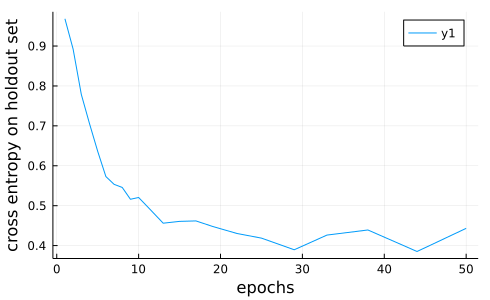

In [48]:
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(fraction_train=0.7), # (default)
                       measure=cross_entropy)

using Plots
gr(size=(490,300))
plt=plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "epochs")
ylabel!(plt, "cross entropy on holdout set")
savefig("learning_curve.png")
plt

We will return to learning curves when we look at tuning in Part 4.

### Resources for Part 2

- From the MLJ manual:
    - [Getting Started](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/)
    - [Model Search](https://alan-turing-institute.github.io/MLJ.jl/dev/model_search/)
    - [Evaluating Performance](https://alan-turing-institute.github.io/MLJ.jl/dev/evaluating_model_performance/) (using `evaluate!`)
    - [Learning Curves](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
    - [Performance Measures](https://alan-turing-institute.github.io/MLJ.jl/dev/performance_measures/) (loss functions, scores, etc)
- From Data Science Tutorials:
    - [Choosing and evaluating a model](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/choosing-a-model/)
    - [Fit, predict, transform](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/fit-and-predict/)

### Exercises for Part 2

#### Exercise 4

(a) Identify all supervised MLJ models that can be applied (without
type coercion or one-hot encoding) to a supervised learning problem
with input features `X4` and target `y4` defined below:

In [49]:
import Distributions
poisson = Distributions.Poisson

age = 18 .+ 60*rand(10);
salary = coerce(rand(["small", "big", "huge"], 10), OrderedFactor);
levels!(salary, ["small", "big", "huge"]);
small = salary[1]

CategoricalArrays.CategoricalValue{String, UInt32} "huge" (3/3)

In [50]:
X4 = DataFrames.DataFrame(age=age, salary=salary)

n_devices(salary) = salary > small ? rand(poisson(1.3)) : rand(poisson(2.9))
y4 = [n_devices(row.salary) for row in eachrow(X4)]

10-element Vector{Int64}:
 2
 2
 1
 1
 0
 3
 7
 1
 6
 5

(b) What models can be applied if you coerce the salary to a
`Continuous` scitype?

#### Exercise 5 (unpack)

After evaluating the following ...

In [51]:
data = (a = [1, 2, 3, 4],
        b = rand(4),
        c = rand(4),
        d = coerce(["male", "female", "female", "male"], OrderedFactor));
pretty(data)

┌───────┬────────────┬────────────┬──────────────────────────────────┐
│ a     │ b          │ c          │ d                                │
│ Int64 │ Float64    │ Float64    │ CategoricalValue{String, UInt32} │
│ Count │ Continuous │ Continuous │ OrderedFactor{2}                 │
├───────┼────────────┼────────────┼──────────────────────────────────┤
│ 1     │ 0.480318   │ 0.669866   │ male                             │
│ 2     │ 0.83416    │ 0.591969   │ female                           │
│ 3     │ 0.669467   │ 0.858711   │ female                           │
│ 4     │ 0.185419   │ 0.361825   │ male                             │
└───────┴────────────┴────────────┴──────────────────────────────────┘


In [52]:
using Tables

y, X, w = unpack(data,
                 ==(:a),
                 name -> elscitype(Tables.getcolumn(data, name)) == Continuous,
                 name -> true);

...attempt to guess the evaluations of the following:

In [53]:
y

4-element Vector{Int64}:
 1
 2
 3
 4

In [54]:
pretty(X)

┌────────────┬────────────┐
│ b          │ c          │
│ Float64    │ Float64    │
│ Continuous │ Continuous │
├────────────┼────────────┤
│ 0.480318   │ 0.669866   │
│ 0.83416    │ 0.591969   │
│ 0.669467   │ 0.858711   │
│ 0.185419   │ 0.361825   │
└────────────┴────────────┘


In [55]:
w

4-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "male"
 "female"
 "female"
 "male"

#### Exercise 6 (first steps in modeling Horse Colic)

Here is the Horse Colic data introduced in Part 1, together with the
type coercions we performed there:

In [56]:
using UrlDownload, CSV
csv_file = urldownload("https://raw.githubusercontent.com/ablaom/"*
                   "MachineLearningInJulia2020/"*
                   "for-MLJ-version-0.16/data/horse.csv");
horse = DataFrames.DataFrame(csv_file); # convert to data frame
coerce!(horse, autotype(horse));
coerce!(horse, Count => Continuous);
coerce!(horse,
        :surgery               => Multiclass,
        :age                   => Multiclass,
        :mucous_membranes      => Multiclass,
        :capillary_refill_time => Multiclass,
        :outcome               => Multiclass,
        :cp_data               => Multiclass);
schema(horse)

┌─────────────────────────┬─────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                         │ _.scitypes       │
├─────────────────────────┼─────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    │
│ age                     │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    │
│ rectal_temperature      │ Float64                         │ Continuous       │
│ pulse                   │ Float64                         │ Continuous       │
│ respiratory_rate        │ Float64                         │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ Multiclass{6}    │
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ Multiclass{3}    │
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} │
│ peristalsis             │ 

(a) Suppose we want to use predict the `:outcome` variable, based on
the remaining variables that are `Continuous` (one-hot encoding
categorical variables is discussed later in Part 3) *while ignoring
the others*.  Extract from the `horse` data set (defined in Part 1)
appropriate input features `X` and target variable `y`. (Do not,
however, randomize the observations.)

(b) Create a 70:30 `train`/`test` split of the data and train a
`LogisticClassifier` model, from the `MLJLinearModels` package, on
the `train` rows. Use `lambda=100` and default values for the
other hyper-parameters. (Although one would normally standardize
(whiten) the continuous features for this model, do not do so here.)
After training:

- (i) Recalling that a logistic classifier (aka logistic regressor) is
  a linear-based model learning a *vector* of coefficients for each
  feature (one coefficient for each target class), use the
  `fitted_params` method to find this vector of coefficients in the
  case of the `:pulse` feature. (You can convert a vector of pairs `v =
  [x1 => y1, x2 => y2, ...]` into a dictionary with `Dict(v)`.)

- (ii) Evaluate the `cross_entropy` performance on the `test`
  observations.

- &star;(iii) In how many `test` observations does the predicted
  probability of the observed class exceed 50%?

- (iv) Find the `misclassification_rate` in the `test`
  set. (*Hint.* As this measure is deterministic, you will either
  need to broadcast `mode` or use `predict_mode` instead of
  `predict`.)

(c) Instead use a `RandomForestClassifier` model from the
    `DecisionTree` package and:

- (i) Generate an appropriate learning curve to convince yourself
  that out-of-sample estimates of the `cross_entropy` loss do not
  substantially improve for `n_trees > 50`. Use default values for
  all other hyper-parameters, and feel free to use all available
  data to generate the curve.

- (ii) Fix `n_trees=90` and use `evaluate!` to obtain a 9-fold
  cross-validation estimate of the `cross_entropy`, restricting
  sub-sampling to the `train` observations.

- (iii) Now use *all* available data but set
  `resampling=Holdout(fraction_train=0.7)` to obtain a score you can
  compare with the `KNNClassifier` in part (b)(iii). Which model is
  better?

<a id='part-3-transformers-and-pipelines'></a>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*